In [1]:
#load supplimentary packages
import os
import matplotlib.pyplot as plt
from copy import deepcopy

plt.rcParams['figure.dpi'] = 300  # For display in notebook

current_directory = os.getcwd()

In [ ]:
#load cuurent experiment packages
from utils.utils import *
from utils.data_generation import *
from utils.constructors import *
from mgym.algorithms import *
sys.path.append(os.path.join(current_directory, "ipsim/ipsim"))

In [3]:
#Setup factories
EnvFactory.constructors['STEP'] = create_env_STEP
ControlFactory.constructors['STEP'] = create_pid_conrol_STEP

# ================ OFFLINE RL RESULTS==========================

In [4]:
#Show evaliation data graphics
def STEP_show_data(algs_data):
    fig = plt.figure(figsize=(12,3))
    plt.subplot(1, 4, 1)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["X1"], label=alg_name)
        plt.plot(_data["X2"])
        plt.plot(_data["X3"])
    plt.ylim(0,1)
    
    plt.subplot(1, 4, 2)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["yA3"])
    plt.ylim(0,1)

    plt.subplot(1, 4, 3)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["F4"])
    plt.ylim(50,150)

    plt.subplot(1, 4, 4)
    for alg_name in algs_data:
        _data = algs_data[alg_name]
        plt.plot(_data["P"])
    plt.ylim(2500,3000)

    plt.gca().legend([_ for _ in algs_data], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [5]:
#show target metricses
#Here we show metrics only for temperature (T) as the most indicative parameter.
def STEP_metrics(metrics_calculators):
    for alg_name in metrics_calculators:
        _mc = metrics_calculators[alg_name]
        print(f"{alg_name}: ISF={_mc.ISF()[2]}; IAE={_mc.IAE()[2]}; ITAE={_mc.ITAE()[2]}; ITSH={_mc.ITSH()[2]};")

In [6]:
#run pretrained models on target scenario
def STEP_assess_offline(config, algs):
    config['normalize'] = False
    config['compute_diffs_on_reward'] = False
    
    _env = EnvFactory.create(config=config)
    _env.reset(initial_state=[])
    config['process_model_obj'] = _env
    control = ControlFactory.create(config=config)

    env_name = config["process_name"]
    location = "offline"
    logdir = os.path.join(os.path.join(os.path.join(".","pretrained"), f"{env_name}"),f"{location}")

    algorithms = []
    algorithms.append( (control, 'baseline', config['normalize'], ) )
    for alg_name in algs :
        algorithms.append( (RLModel(alg_name, logdir), alg_name, config['normalize'], ) )

    setpoints  = np.array([0.63, 130.0, 2850.0, ],dtype=np.float32)
    
    processes_data = {}
    metrics_calculators = {}
    for alg, alg_name, normalize in algorithms:
        if alg_name != 'baseline':
            _env = EnvFactory.create(config=config)
            _env.reset(initial_state=[])

        processes_data[alg_name] = None
        metrics_calculators[alg_name] = MetricsCalculator(setpoints=setpoints, dt = 1)
        _mc = metrics_calculators[alg_name]

        iterations = 500    
        _process_data = {"X1":[], "X2":[], "X3":[], "yA3":[], "F4":[], "P":[], }
        _state = _env.process_model.step()

        for _ in range(iterations):
            _u = alg.predict(_state)
            _process_data["X1"].append(_u[0])
            _process_data["X2"].append(_u[1])
            _process_data["X3"].append(_u[2])
            
            _mc.update(_state)
            _observation, _reward, _done, _info = _env.step(action=_u)
            _state = _observation
            
            _process_data["yA3"].append(_state[0])
            _process_data["F4"].append(_state[1])
            _process_data["P"].append(_state[2])

        processes_data[alg_name] = _process_data

    return processes_data, metrics_calculators

In [ ]:
config = load_config_yaml(current_directory, 'STEP')
processes_data, metrics_calculators = STEP_assess_offline(config=config, algs=[ 'COMBO'
                                                                      , 'MOPO'
                                                                      , 'BC'
                                                                      , 'CQL'
                                                                      , 'PLAS'
                                                                      , 'PLASWithPerturbation'
                                                                      , 'BEAR'
                                                                      , 'SAC'
                                                                      , 'BCQ'
                                                                      , 'CRR'
                                                                      , 'AWAC'
                                                                      , 'DDPG'
                                                                      , 'TD3'
                                                                      ])

In [8]:
STEP_metrics(metrics_calculators)

baseline: ISF=164135.18899526604; IAE=3804.3897971760807; ITAE=407454.010942093; ITSH=8367566.997975014;
COMBO: ISF=342976.43346727424; IAE=7654.264089025731; ITAE=1737607.9692003063; ITSH=51481199.37562425;
MOPO: ISF=5126737.866392364; IAE=34872.071418084306; ITAE=9324772.973463707; ITSH=1394980172.6013353;
BC: ISF=434585.2701004868; IAE=9676.650620722405; ITAE=2500162.33060935; ITSH=106047428.97645022;
CQL: ISF=185729.93299371644; IAE=3976.569916305741; ITAE=489943.5730175211; ITSH=8244163.620198814;
PLAS: ISF=4201035.214690627; IAE=30913.65273801842; ITAE=8874161.159590319; ITSH=1288733917.6876686;
PLASWithPerturbation: ISF=4027962.6394715356; IAE=30009.875149080333; ITAE=8718548.418347908; ITSH=1255172349.651949;
BEAR: ISF=99848.86102862984; IAE=2502.8211303104317; ITAE=210931.58105517988; ITSH=4273231.726469282;
SAC: ISF=1841771.7714502634; IAE=19302.66554318224; ITAE=5109801.150425698; ITSH=487161462.51405007;
BCQ: ISF=132525.3661036958; IAE=3600.350652283661; ITAE=473840.2626913

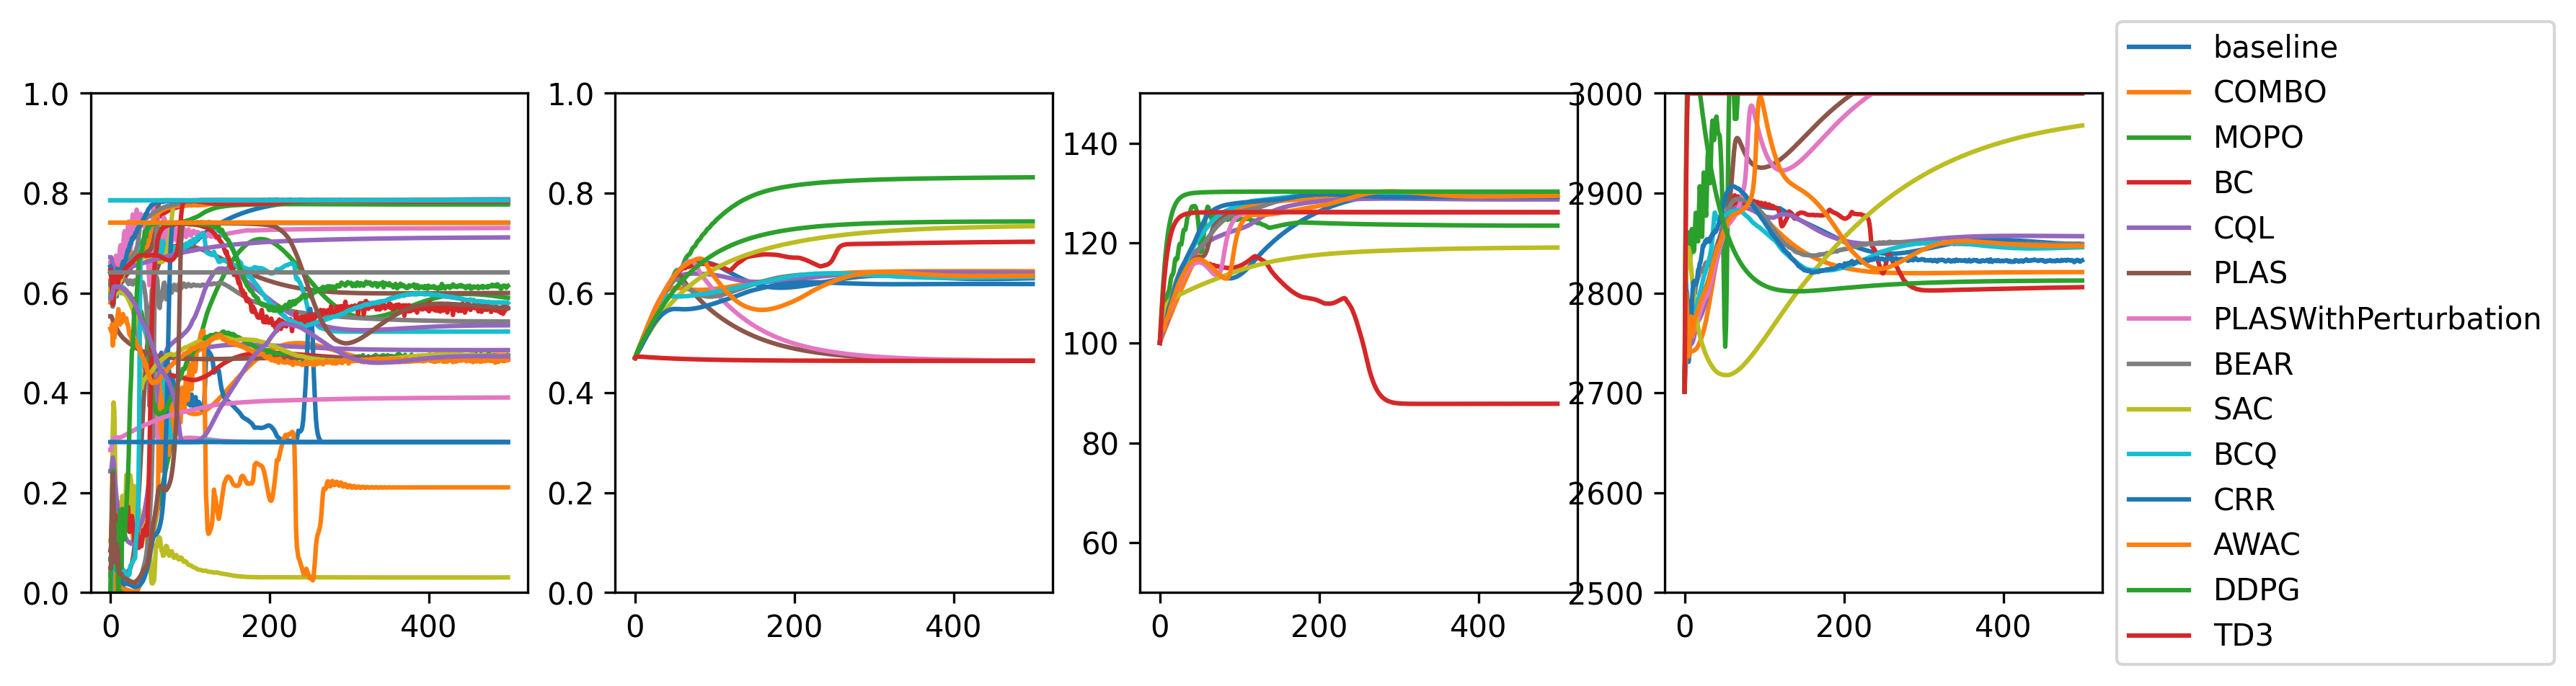

In [10]:
STEP_show_data(processes_data)

In [11]:
#show only graphics with best performance

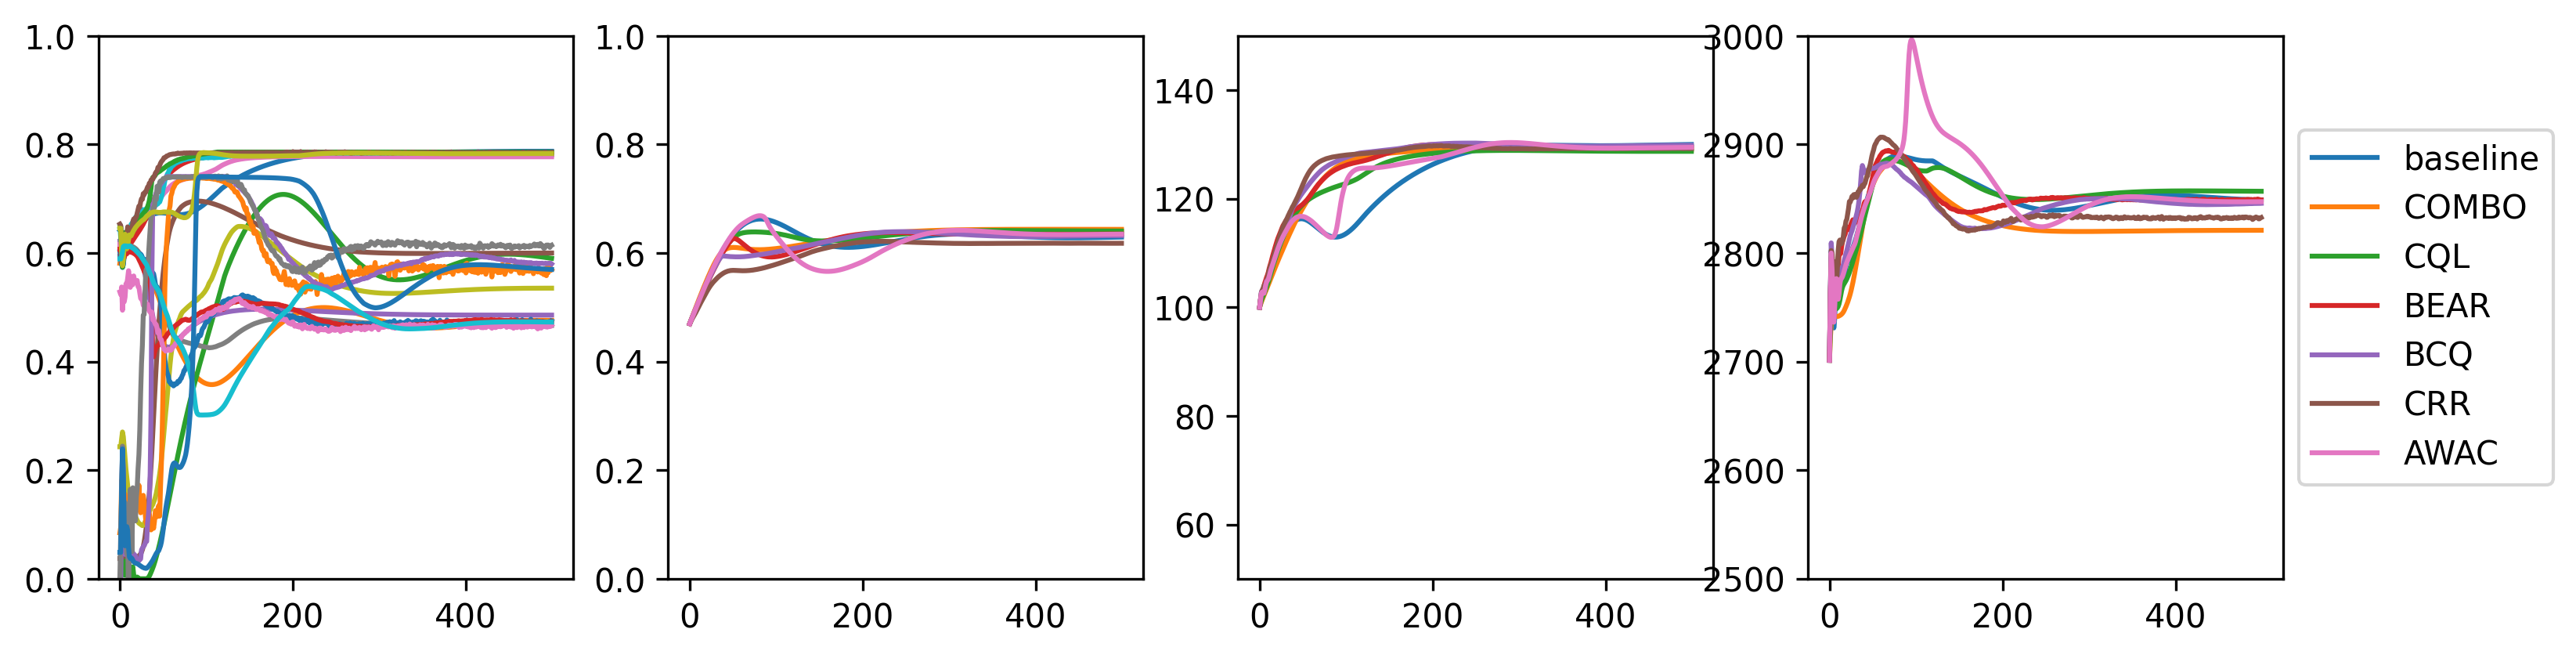

In [12]:
best_data = {}
for alg in ['baseline', 'COMBO', 'CQL', 'BEAR', 'BCQ', 'CRR', 'AWAC',]:
    best_data[alg] = processes_data[alg]
STEP_show_data(best_data)

# ================ ONLINE RL RESULTS==========================

In [13]:
import ray as ray 
from ray import tune
from ray.tune.registry import register_env
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLogger

In [14]:
AlgorithmsFactory.constructors["a2c"] = setup_alg_a2c
AlgorithmsFactory.constructors["a3c"] = setup_alg_a3c
AlgorithmsFactory.constructors["ars"] = setup_alg_ars
AlgorithmsFactory.constructors["ppo"] = setup_alg_ppo
AlgorithmsFactory.constructors["sac"] = setup_alg_sac
AlgorithmsFactory.constructors["impala"] = setup_alg_impala

In [15]:
env_name = 'STEP'
config['normalize'] = True
config['compute_diffs_on_reward'] = False
logdir = os.path.join(os.path.join(os.path.join(current_directory,"pretrained"), f"{env_name}"),f"online")

In [16]:
def STEP_case(algorithms, config):
    setpoints  = np.array([0.63, 130.0, 2850.0, ],dtype=np.float32)
        
    processes_data = {}
    metrics_calculators = {}
    for alg, alg_name in algorithms:
        _env = EnvFactory.create(config=config)
        _state = _env.reset(initial_state = [])

        alg.process = _env
        
        processes_data[alg_name] = None
        metrics_calculators[alg_name] = MetricsCalculator(setpoints=setpoints, dt = 0.1)
        _mc = metrics_calculators[alg_name]

        iterations = 300    
        _process_data = {"X1":[], "X2":[], "X3":[], "yA3":[], "F4":[], "P":[], }
        for _ in range(iterations):
            _u = alg.predict(_state)
            dn_u = _env.denormalize_actions(_u) 
            _process_data["X1"].append(dn_u[0])
            _process_data["X2"].append(dn_u[1])
            _process_data["X3"].append(dn_u[2])
            
            _observation, _reward, _done, _info = _env.step(action=_u)
            _state = _observation
            
            dn_s = _env.denormalize_observations(_state)
            _mc.update(dn_s)
            
            _process_data["yA3"].append(dn_s[0])
            _process_data["F4"].append(dn_s[1])
            _process_data["P"].append(dn_s[2])
        
        processes_data[alg_name] = _process_data

    return processes_data, metrics_calculators

In [17]:
def STEP_assess_online(config, algs ):    
    processes_data = {}
    metrics_calculators = {}
    for alg_name in algs:
        try:
            rl_trainer, rl_config = AlgorithmsFactory.create(alg_name=alg_name,config = config)
            env_config = {
                "env_name": env_name,
                "normalize": config['normalize'],
                "dense_reward": config['dense_reward'],
                "compute_diffs_on_reward": config['compute_diffs_on_reward'],    
            }
            
            def env_creator(env_config):
                return create_env_STEP(config)
                
            register_env("STEP", env_creator)
             
            checkpoint_path = os.path.join(logdir,alg_name)
            checkpoint_path = os.path.join(checkpoint_path,'best')
            checkpoint_path = os.path.join(checkpoint_path,'best') 
            
            rl_config["env_config"] = env_config
            rl_config["framework"] = "torch"
            rl_config["evaluation_interval"] = int(config['train_iter'] / 10)
            agent = rl_trainer(rl_config, env=config['process_name'])
            agent.restore(checkpoint_path)
        
            algorithms=[]
            algorithms.append((RayAgentWrapper(agent=agent),alg_name,))
        
            _process_data, _metrics_calculators = STEP_case(algorithms=algorithms, config=config)
        
            processes_data[alg_name] = _process_data[alg_name]
            metrics_calculators[alg_name] = _metrics_calculators[alg_name]
                
        except Exception as exception:
            print(f'{alg_name} exception: {exception}')

    return processes_data, metrics_calculators

In [28]:
def STEP_baseline(config):    
    algorithms=[]
    algorithms.append((BaselineAlgorithmWraper(ControlFactory.create(config=config), env=EnvFactory.create(config=config)), 'baseline', ) )
    process_data, metrics_calculators = STEP_case(algorithms=algorithms, config=config)
    return process_data, metrics_calculators

In [ ]:
processes_data, metrics_calculators = STEP_assess_online(config, algs = [
                                                                          'ppo'
                                                                        , 'sac'
                                                                        , 'a2c'
                                                                        , 'a3c'
                                                                        , 'ars'
                                                                        , 'impala'
                                                                        ])

In [29]:
baseline_data, baseline_calculators = STEP_baseline(config = config)
processes_data['baseline'] = baseline_data['baseline']
metrics_calculators['baseline'] = baseline_calculators['baseline']

In [30]:
STEP_metrics(metrics_calculators)

sac: ISF=303433.43482261937; IAE=2001.6473207853146; ITAE=32845.01991301394; ITSH=4959332.758127393;
baseline: ISF=33379.1867436956; IAE=628.6568327741634; ITAE=10670.001032192695; ITSH=571297.8604034883;


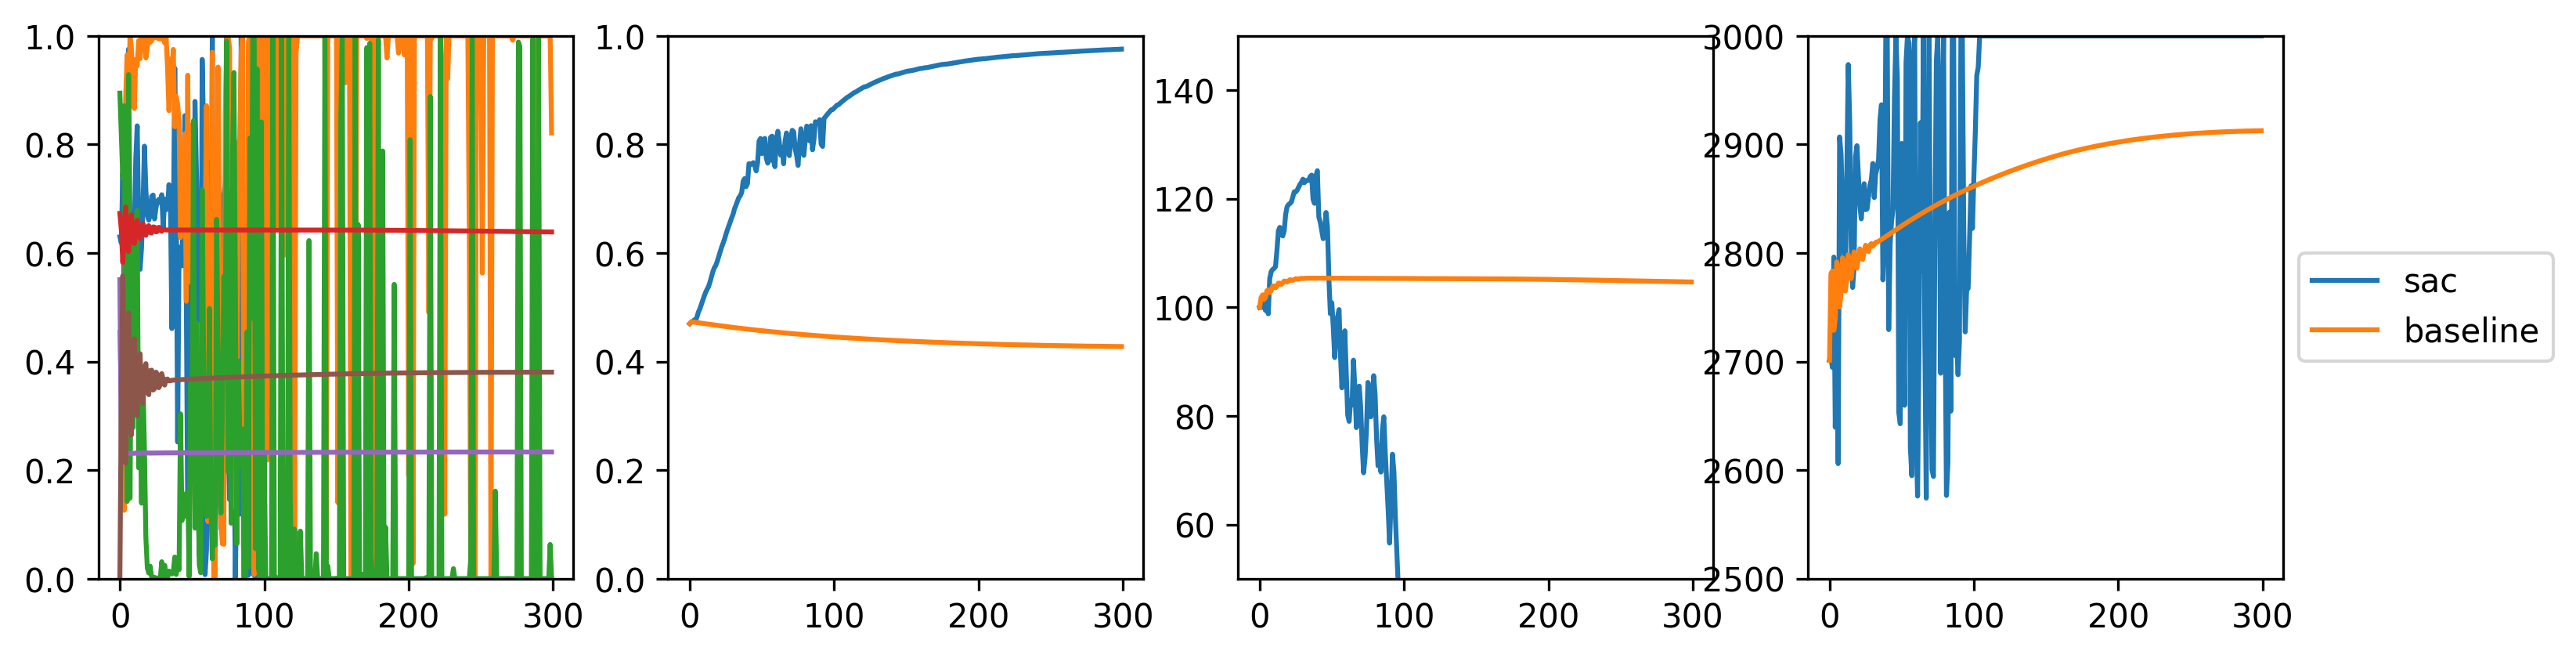

In [31]:
STEP_show_data(processes_data)